In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

import pandas as pd
import numpy as np
#import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


# Importing the dataset (ofertas_relampago.csv)

In [2]:
df_orig = pd.read_csv('ofertas_relampago.csv')

df = df_orig.copy()
original_cols = df.columns.to_list()
df.head()

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES


In [3]:
print(f'The dataframe contains {df.shape[0]} rows (observations) and {df.shape[1]} columns (attributes) \n')
print('-'*100)
print('COLUMNS AND THEIR DATATYPES:\n')
print(df.dtypes)
print('-'*100)
print('DESCRIPTION OF THE NUMERICAL DATA:')
df.describe()

The dataframe contains 48746 rows (observations) and 13 columns (attributes) 

----------------------------------------------------------------------------------------------------
COLUMNS AND THEIR DATATYPES:

OFFER_START_DATE              object
OFFER_START_DTTM              object
OFFER_FINISH_DTTM             object
OFFER_TYPE                    object
INVOLVED_STOCK                 int64
REMAINING_STOCK_AFTER_END      int64
SOLD_AMOUNT                  float64
SOLD_QUANTITY                float64
ORIGIN                        object
SHIPPING_PAYMENT_TYPE         object
DOM_DOMAIN_AGG1               object
VERTICAL                      object
DOMAIN_ID                     object
dtype: object
----------------------------------------------------------------------------------------------------
DESCRIPTION OF THE NUMERICAL DATA:


,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY
count,48746.000000,48746.000000,24579.000000,24579.000000
mean,35.007508,30.565216,51.208898,10.851052
std,206.761058,195.813806,175.254414,45.475305
min,1.000000,-192.000000,0.280000,1.000000
25%,5.000000,4.000000,5.730000,1.000000
50%,10.000000,8.000000,12.420000,3.000000
75%,15.000000,15.000000,30.925000,6.000000
max,9000.000000,8635.000000,4836.570000,1646.000000


In [4]:
num_cols = df.select_dtypes(include='number').columns.tolist()
str_cols = df.select_dtypes(include='object').columns.tolist()
bool_cols = df.select_dtypes(include='bool').columns.tolist()
dt_cols = df.select_dtypes(include='datetimetz').columns.tolist()

print('-'*100) # -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- -- 

print(f'NUMERIC COLUMNS: {len(num_cols)}')
if len(num_cols) > 0:
    for col in num_cols:
        print(f'- {col}: {df[col].dtype}')
    print('(num_cols list created with all numeric type columns\' names)')
else:
    print('- (No numeric columns)')

print('-'*100) # -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- -- 

print(f'STRING COLUMNS: {len(str_cols)}')
if len(str_cols) > 0:
    for col in str_cols:
        print(f'- {col}: {df[col].dtype}')
    print('(str_cols list created with all string/object type columns\' names)')
else:
    print('- (No string columns)')

print('-'*100) # -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- -- 

print(f'DATETIME COLUMNS: {len(dt_cols)}')
if len(dt_cols) > 0:
    for col in dt_cols:
        print(f'- {col}: {df[col].dtype}')
    print('(dt_cols list created with all datetime type columns\' names)')
else:
    print('- (No datetime columns)')

print('-'*100) # -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- -- 

print(f'BOOLEAN COLUMNS: {len(bool_cols)}')
if len(bool_cols) > 0:
    for col in bool_cols:
        print(f'- {col}: {df[col].dtype}')
    print('(bool_cols list created with all boolean type columns\' names)')
else:
    print('- (No boolean columns)')

print('-'*100) # -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- --  -- -- 

----------------------------------------------------------------------------------------------------
NUMERIC COLUMNS: 4
- INVOLVED_STOCK: int64
- REMAINING_STOCK_AFTER_END: int64
- SOLD_AMOUNT: float64
- SOLD_QUANTITY: float64
(num_cols list created with all numeric type columns' names)
----------------------------------------------------------------------------------------------------
STRING COLUMNS: 9
- OFFER_START_DATE: object
- OFFER_START_DTTM: object
- OFFER_FINISH_DTTM: object
- OFFER_TYPE: object
- ORIGIN: object
- SHIPPING_PAYMENT_TYPE: object
- DOM_DOMAIN_AGG1: object
- VERTICAL: object
- DOMAIN_ID: object
(str_cols list created with all string/object type columns' names)
----------------------------------------------------------------------------------------------------
DATETIME COLUMNS: 0
- (No datetime columns)
----------------------------------------------------------------------------------------------------
BOOLEAN COLUMNS: 0
- (No boolean columns)
---------------------

# Missing Values

In [5]:
print(f'total number of rows: {len(df):,}')
df_null_analysis = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'col_name', 0:'null_rows'})
df_null_analysis['null_rows_pct'] = (df_null_analysis['null_rows']/len(df)*100).round(1).astype(str)+'%'
df_null_analysis

total number of rows: 48,746


,col_name,null_rows,null_rows_pct
0,OFFER_START_DATE,0,0.0%
1,OFFER_START_DTTM,0,0.0%
2,OFFER_FINISH_DTTM,0,0.0%
3,OFFER_TYPE,0,0.0%
4,INVOLVED_STOCK,0,0.0%
5,REMAINING_STOCK_AFTER_END,0,0.0%
6,SOLD_AMOUNT,24167,49.6%
7,SOLD_QUANTITY,24167,49.6%
8,ORIGIN,37430,76.8%
9,SHIPPING_PAYMENT_TYPE,0,0.0%


We have in this dataframe 3 columns with missing values.

We will treat each datatype separately and understand if there are 'strange' values before filling na or dropping na

# Feature Analysis

## Datetime columns and their values

Right away we can see that there are some date and datetime columns that are currently in string (object) type.
To be able to make date and time comparissons we will need to convert them to datetime type.

- OFFER_START_DATE
- OFFER_START_DTTM
- OFFER_FINISH_DTTM

In [6]:
df['OFFER_START_DATE_dt'] = pd.to_datetime(df['OFFER_START_DATE'])
df['OFFER_FINISH_DTTM_dt'] = pd.to_datetime(df['OFFER_FINISH_DTTM'])
df['OFFER_START_DTTM_dt'] = pd.to_datetime(df['OFFER_START_DTTM'])

print(
    df[['OFFER_START_DATE', 'OFFER_START_DATE_dt',
        'OFFER_START_DTTM', 'OFFER_START_DTTM_dt',
        'OFFER_FINISH_DTTM', 'OFFER_FINISH_DTTM_dt'
        ]].dtypes
)

df[['OFFER_START_DATE', 'OFFER_START_DATE_dt',
    'OFFER_START_DTTM', 'OFFER_START_DTTM_dt',
    'OFFER_FINISH_DTTM', 'OFFER_FINISH_DTTM_dt'
    ]].head(2)

OFFER_START_DATE                     object
OFFER_START_DATE_dt          datetime64[ns]
OFFER_START_DTTM                     object
OFFER_START_DTTM_dt     datetime64[ns, UTC]
OFFER_FINISH_DTTM                    object
OFFER_FINISH_DTTM_dt    datetime64[ns, UTC]
dtype: object


,OFFER_START_DATE,OFFER_START_DATE_dt,OFFER_START_DTTM,OFFER_START_DTTM_dt,OFFER_FINISH_DTTM,OFFER_FINISH_DTTM_dt
0,2021-06-22,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,2021-06-22 23:02:43+00:00
1,2021-06-22,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,2021-06-22 19:00:02+00:00


### Datetime columns analysis

We will understand now if there are any weird values in the datetime columns

We will also understand how the data is distributed through time

In [7]:
print('OFFER_START_DATE')
print(f"- Oldest 'Offer Start Date': {min(df["OFFER_START_DTTM_dt"].dt.date)}")
print(f"- Most recent 'Offer Start Date': {max(df["OFFER_START_DTTM_dt"].dt.date)}")
print('-'*100)
print('OFFER_FINISH_DTTM')
print(f"- Oldest 'Offer End Date': {min(df["OFFER_FINISH_DTTM_dt"].dt.date)}")
print(f"- Most recent 'Offer End Date': {max(df["OFFER_FINISH_DTTM_dt"].dt.date)}")


OFFER_START_DATE
- Oldest 'Offer Start Date': 2021-06-01
- Most recent 'Offer Start Date': 2021-07-31
----------------------------------------------------------------------------------------------------
OFFER_FINISH_DTTM
- Oldest 'Offer End Date': 2021-06-01
- Most recent 'Offer End Date': 2021-08-01


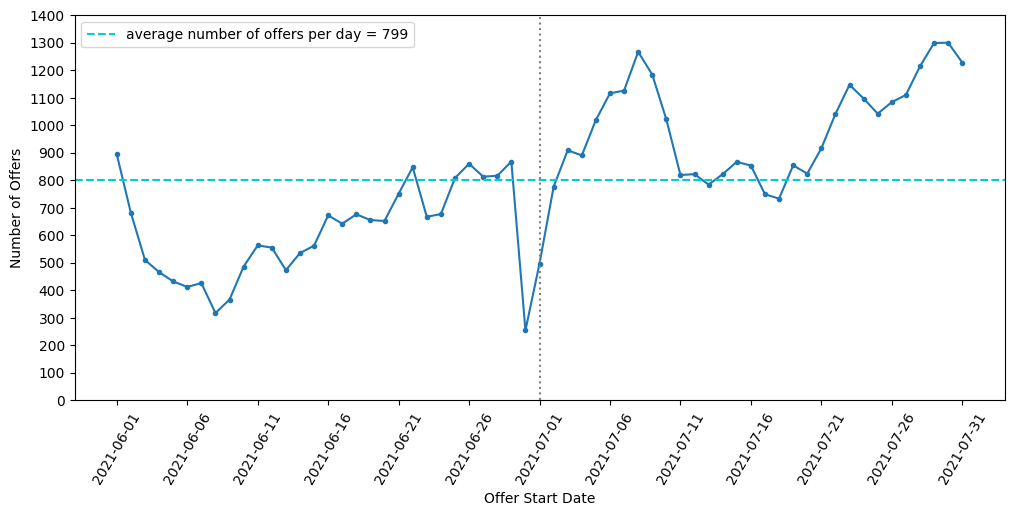

In [51]:
'''Let's plot the number of offers per offer start date to see if there is any concentration in a specific date'''
df_ts_temp = df[['OFFER_START_DATE_dt']].reset_index().groupby('OFFER_START_DATE_dt').agg(num_offers=('index','count')).copy()

import datetime as dt

plt.figure(figsize=(12,5))
plt.plot(df_ts_temp, marker='.')

plt.yticks(range(0,round(max(df_ts_temp['num_offers']),-2)+200,100))
plt.ylabel('Number of Offers')
plt.axhline(np.mean(df_ts_temp['num_offers']), ls='--', c='darkturquoise', label=f'average number of offers per day = {int(np.mean(df_ts_temp['num_offers']))}')

plt.xticks([df_ts_temp.reset_index()['OFFER_START_DATE_dt'][i] for i in range(0,len(df_ts_temp),5)],rotation=60)
plt.xlabel('Offer Start Date')
plt.axvline(dt.date(2021,7,1), ls=':', c='gray')

plt.legend()

plt.show()

#df_ts_temp.

We can visually confirm that all offers have started between the 2021-06-01 and 2021-07-31

In [52]:
df_ts = df.copy()

df_ts['offer_duration_seconds'] = (df_ts['OFFER_FINISH_DTTM_dt']-df_ts['OFFER_START_DTTM_dt']).dt.total_seconds().astype(int)

# Let's remove the records for which offer durition = 0, for they are irrelevant for our analysis
print(f'lenght of the df BEFORE duration=0 removal: {len(df_ts)}')
#df_ts = df_ts[df_ts['offer_duration_seconds']>0]
print(f'lenght of the df AFTER duration=0 removal: {len(df_ts)}')

df_ts.columns

df_ts.isnull().sum()

lenght of the df BEFORE duration=0 removal: 48746
lenght of the df AFTER duration=0 removal: 48746


OFFER_START_DATE                 0
OFFER_START_DTTM                 0
OFFER_FINISH_DTTM                0
OFFER_TYPE                       0
INVOLVED_STOCK                   0
REMAINING_STOCK_AFTER_END        0
SOLD_AMOUNT                  24167
SOLD_QUANTITY                24167
ORIGIN                       37430
SHIPPING_PAYMENT_TYPE            0
DOM_DOMAIN_AGG1                  0
VERTICAL                         0
DOMAIN_ID                        0
OFFER_START_DATE_dt              0
OFFER_FINISH_DTTM_dt             0
OFFER_START_DTTM_dt              0
offer_duration_seconds           0
dtype: int64

### FIXING STOCK AND SALES DATA

In [53]:
'''
We will fill na for the columns that we can interpret, SOLD_AMOUNT and SOLD_QUANTITY, 
which we can assume that if missing, then 0.
'''
df_ts['SOLD_AMOUNT'].fillna(0,inplace=True)
df_ts['SOLD_QUANTITY'].fillna(0,inplace=True)

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
# Let's fix the data, considering that there are some records that show more sales than there is stock.

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 'sold_quantity_fixed'
'''
We will start by fixing 'SOLD_QUANTITY'. If 'SOLD_QUANTITY' > 'INVOLVED_STOCK' then 'INVOLVED_STOCK' else 'SOLD_QUANTITY'.
We shall start with creating a function to then apply it to our df and create the fixed column
'''

def sold_qty_fixer(stock,sales):
    if sales > stock:
        return stock
    else:
        return sales

df_ts['sold_quantity_fixed'] = (df_ts.apply(lambda x: sold_qty_fixer(x.INVOLVED_STOCK, x.SOLD_QUANTITY), axis=1)).astype(int)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 'remaining_stock_after_end_fixed'
''' 
Now we can fix the 'REMAINING_STOCK_AFTER_END' column, by subtracting the new 'sold_quantity_fixed' from the 'INVOLVED_STOCK'
'''

df_ts['remaining_stock_after_end_fixed'] = (df_ts['INVOLVED_STOCK']-df_ts['sold_quantity_fixed']).astype(int)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 'sold_amount_fixed'
'''
Finally, we will fix the 'SOLD_AMOUNT' column by dividing it by the previous/wrong 'SOLD_QUANTITY' 
and multiplying this unit price by the new/fixed 'sold_quantity_fixed'
(Here I am assuming that the SOLD_AMOUNT reflects the SOLD_QUANTITY times unit price, which I cannot validate with the given data)
'''

df_ts['sold_amount_fixed'] = (df_ts['SOLD_AMOUNT']/df_ts['SOLD_QUANTITY'])*df_ts['sold_quantity_fixed']
df_ts['sold_amount_fixed'].fillna(0, inplace=True)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
cols_df_ts = ['offer_duration_seconds',
              'INVOLVED_STOCK', 'SOLD_QUANTITY',
              'sold_quantity_fixed',
              'SOLD_AMOUNT','sold_amount_fixed',
              'REMAINING_STOCK_AFTER_END','remaining_stock_after_end_fixed'
              ]

df_ts[cols_df_ts].head()



,offer_duration_seconds,INVOLVED_STOCK,SOLD_QUANTITY,sold_quantity_fixed,SOLD_AMOUNT,sold_amount_fixed,REMAINING_STOCK_AFTER_END,remaining_stock_after_end_fixed
0,25363,4,6.0,4,4.72,3.146667,-2,0
1,21602,5,0.0,0,0.00,0.000000,5,5
2,21601,15,3.0,3,10.73,10.730000,12,12
3,23772,15,2.0,2,7.03,7.030000,13,13
4,10092,15,15.0,15,39.65,39.650000,0,0


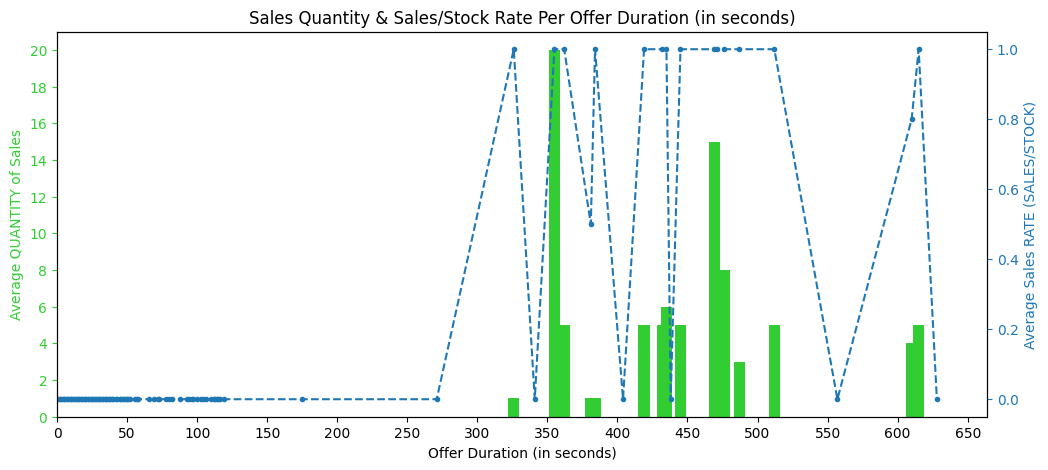

In [111]:
# FEATURE ENGINEERING (Variable of Interest)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# sales_rate: Percentage of the INVOLVED_STOCK that was sold (INVOLVED_STOCK/sold_quantity_fixed).
'''
Observing the data, it would be interesting to understand the relationship between our features (independent variables) and some
rate of success (dependent variable).
In this case we could create a new column containing the rate of SALES/STOCK. We will have a percentage of the INVOLVED_STOCK
that was actually sold (SOLD_QUANTITY).
Considering that we have cleaned the data, we can now execute this logic and create this feature of interest quite simply.
'''

df_ts['sales_rate'] = df_ts['sold_quantity_fixed']/df_ts['INVOLVED_STOCK']

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
'''
Now, we are read to understand the relationship between the different variables available and our variable of interest, 
which we are using as a measure of success ('sales_rate').

ALERT! We must keep in mind that the percentage of sales could be, and probably is, biased by the duration of the offer,
that is, offers that stay active for longer have more chances of materializing into more sales than those that 
stay active for shorter time periods.
With that being said, we will start by observing the relationship between offer duration and sales_rate.
'''


df_ts_grp = df_ts[['offer_duration_seconds', 
                   'sales_rate', 
                   'sold_quantity_fixed'
                   ]].groupby('offer_duration_seconds'
                             ).agg(avg_sales_rate=('sales_rate','mean'),
                                   avg_sales_qty=('sold_quantity_fixed','mean')
                                   )


fig, ax1 = plt.subplots(figsize=(12,5))
ax1.set_title('Sales Quantity & Sales/Stock Rate Per Offer Duration (in seconds)')
ax1.bar(x=df_ts_grp[['avg_sales_qty']].reset_index()['offer_duration_seconds'].iloc[:100], 
        height=df_ts_grp[['avg_sales_qty']].reset_index()['avg_sales_qty'].iloc[:100],
        width=8,
        color='limegreen')
ax1.set_xlabel('Offer Duration (in seconds)')
ax1.set_ylabel('Average QUANTITY of Sales')
ax1.yaxis.label.set_color('limegreen')
ax1.tick_params(axis='y', colors='limegreen')
ax1.set_yticks(range(0, int(df_ts_grp['avg_sales_qty'].iloc[:100].max())+2,2))
ax1.set_xticks(range(0, round(int(df_ts_grp[['avg_sales_qty']].reset_index()['offer_duration_seconds'].iloc[:100].max()),-2)+100,50))
#ax1.axvline(300, c='gray', ls=':', label='We start seeing sales for offer durations (in seconds) \n starting at around 300 seconds (5 minutes)')
ax1.set_xlim(xmin=0)

ax2 = ax1.twinx()

ax2.plot(df_ts_grp['avg_sales_rate'].iloc[:100], '--', marker='.', c='#1f77b4')
ax2.set_ylabel('Average Sales RATE (SALES/STOCK)')
ax2.yaxis.label.set_color('#1f77b4')
ax2.tick_params(axis='y', colors='#1f77b4')

#fig.legend(loc='best', fontsize='small')


We start seeing sales for offer durations (in seconds) starting at around 300 seconds (5 minutes).

This could indicate that any offer with a duration less than 300 seconds (5 minutes) could be disconsidered for it does not perform in sales.

### Feature Engineering (Date columns)

Let's try to find out more about these offers 'oferta relâmpago" and how long they last

#### Offer Duration

In [113]:
df['offer_duration'] = (df['OFFER_FINISH_DTTM_dt']-df['OFFER_START_DTTM_dt'])
df['offer_duration_seconds'] = (df['OFFER_FINISH_DTTM_dt']-df['OFFER_START_DTTM_dt']).dt.total_seconds().astype(int)
df['offer_duration_minutes'] = (df['OFFER_FINISH_DTTM_dt']-df['OFFER_START_DTTM_dt']).dt.total_seconds().astype(int)//60
df['offer_duration_hours'] = (df['OFFER_FINISH_DTTM_dt']-df['OFFER_START_DTTM_dt']).dt.total_seconds().astype(int)//60//60
df['offer_duration_days'] = (df['OFFER_FINISH_DTTM_dt']-df['OFFER_START_DTTM_dt']).dt.total_seconds().astype(int)//60//60//24

df[['OFFER_START_DTTM','OFFER_FINISH_DTTM', 'offer_duration', 'offer_duration_seconds', 'offer_duration_minutes', 'offer_duration_hours','offer_duration_days']]

,OFFER_START_DTTM,OFFER_FINISH_DTTM,offer_duration,offer_duration_seconds,offer_duration_minutes,offer_duration_hours,offer_duration_days
0,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,0 days 07:02:43,25363,422,7,0
1,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,0 days 06:00:02,21602,360,6,0
2,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,0 days 06:00:01,21601,360,6,0
3,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,0 days 06:36:12,23772,396,6,0
4,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,0 days 02:48:12,10092,168,2,0
...,...,...,...,...,...,...,...
48741,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,0 days 06:00:01,21601,360,6,0
48742,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,0 days 06:00:01,21601,360,6,0
48743,2021-06-19 07:00:00+00:00,2021-06-19 13:00:03+00:00,0 days 06:00:03,21603,360,6,0
48744,2021-06-19 13:00:00+00:00,2021-06-19 19:00:00+00:00,0 days 06:00:00,21600,360,6,0


In [114]:
def print_elapsed(elapsed):
    if elapsed < 60:
        magnitude = 'seconds'
        print(elapsed, 
            magnitude)
    elif elapsed <= 60**2:
        magnitude = 'minutes'
        print(elapsed//60, 
            magnitude if elapsed//60 != 1 else magnitude[:-1], ',', 
            elapsed%60, 
            'seconds' if elapsed%60 != 1 else 'second')
    elif elapsed < 60**2*24:
        magnitude = 'hours'
        print(elapsed//(60**2),
            magnitude if elapsed//(60**2) != 1 else magnitude[:-1], ',', 
            (elapsed%(60**2))//60, 
            'minutes,' if (elapsed%(60**2))//60 != 1 else 'minute,',
            (elapsed%(60**2))%60, 
            'seconds' if (elapsed%(60**2))%60 != 1 else 'second')
    elif elapsed < 60**2*24*7:
        magnitude = 'days'
        print(elapsed//(60**2*24), 
            magnitude if elapsed//(60**2*24) != 1 else magnitude[:-1], ',',
            (elapsed%(60**2*24))//(60**2), 
            'hours,' if (elapsed%(60**2*24))//(60**2) != 1 else 'hour,',
            ((elapsed%(60**2*24))%(60**2))//60, 
            'minutes,' if ((elapsed%(60**2*24))%(60**2))//60 != 1 else 'minute,',
            ((elapsed%(60**2*24))%(60**2))%60, 
            'seconds' if ((elapsed%(60**2*24))%(60**2))%60 != 1 else 'second')
    else: 
        magnitude = 'weeks'
        print(elapsed//(60**2*24*7), 
            magnitude if elapsed//(60**2*24*7) != 1 else magnitude[:-1], ',',
            (elapsed%(60**2*24*7))//(60**2*24), 
            'days,' if (elapsed%(60**2*24*7))//(60**2*24) != 1 else 'day,',
            ((elapsed%(60**2*24*7))%(60**2*24))//(60**2), 
            'hours,' if ((elapsed%(60**2*24*7))%(60**2*24))//(60**2) != 1 else 'hour,',
            (((elapsed%(60**2*24*7))%(60**2*24))%(60**2))//60, 
            'minutes,' if (((elapsed%(60**2*24*7))%(60**2*24))%(60**2))//60 != 1 else 'minute,',
            ((((elapsed%(60**2*24*7))%(60**2*24))%(60**2))%60)%60, 
            'seconds' if ((((elapsed%(60**2*24*7))%(60**2*24))%(60**2))%60)%60 != 1 else 'second')



In [115]:
from scipy.stats import mode
def new_mode(a):
    return mode(a)[0]

print('-'*100)
for op in [min, max, np.mean, np.median, new_mode, np.var, np.std]:
    print(f'{op.__name__.upper().replace('NEW_','')} offer duration:')
    print(f'{int(op(df['offer_duration_seconds'])):,} seconds')
    print_elapsed(op(df['offer_duration_seconds']))       
    print('-'*100)

----------------------------------------------------------------------------------------------------
MIN offer duration:
0 seconds
0 seconds
----------------------------------------------------------------------------------------------------
MAX offer duration:
377,109 seconds
4 days , 8 hours, 45 minutes, 9 seconds
----------------------------------------------------------------------------------------------------
MEAN offer duration:
20,550 seconds
5.0 hours , 42.0 minutes, 30.03990070980217 seconds
----------------------------------------------------------------------------------------------------
MEDIAN offer duration:
21,602 seconds
6.0 hours , 0.0 minutes, 2.0 seconds
----------------------------------------------------------------------------------------------------
MODE offer duration:
21,601 seconds
6 hours , 0 minutes, 1 second
----------------------------------------------------------------------------------------------------
VAR offer duration:
57,867,483 seconds
95.0 weeks

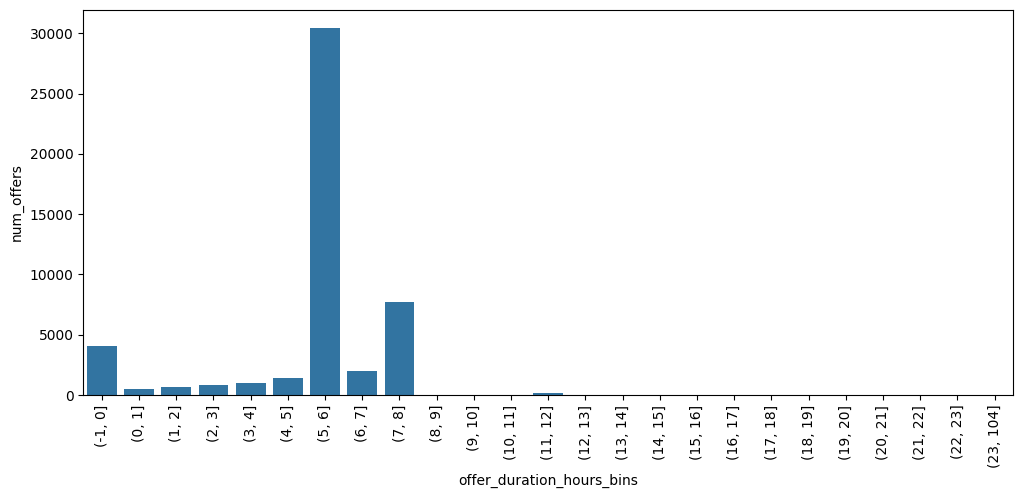

In [116]:
bins = list(range(-1,24))+[max(df['offer_duration_hours'])]

df_duration = df.copy()
df_duration['offer_duration_hours_bins'] = pd.cut(df_duration['offer_duration_hours'], bins=bins, right=True)
#df_duration['offer_duration_hours_bin_num'] = pd.cut(df_duration['offer_duration_hours'], bins=bins, right=True, retbins=True)
df_duration.reset_index(inplace=True)
df_duration.rename(columns={'index':'offer_id'}, inplace=True)

df_duration_grp = df_duration[['offer_id','offer_duration_hours_bins']].groupby('offer_duration_hours_bins').agg(num_offers=('offer_id','nunique')).reset_index()

plt.figure(figsize=(12,5))
sns.barplot(x='offer_duration_hours_bins', y='num_offers', data=df_duration_grp[['offer_duration_hours_bins','num_offers']])
plt.xticks(rotation=90)
plt.show()



In [117]:
df_duration_grp['pct_offers'] = df_duration_grp['num_offers']/len(df_duration)

df_duration_grp.sort_values('pct_offers', ascending=False).head(5)

,offer_duration_hours_bins,num_offers,pct_offers
6,"(5, 6]",30419,0.624031
8,"(7, 8]",7698,0.157921
0,"(-1, 0]",4101,0.084130
7,"(6, 7]",2013,0.041296
5,"(4, 5]",1419,0.029110


- We can see that there is a big concentration in the interval (5,6], meaning that most offers (62.4%) stayed active for more than 5 hours and up to 6 hours.
- The second biggest concentration of offers per duration is in the interval (7,8], that is, 15.8% of all offers stayed active for more than 7 hours and up to 8 hours.

#### Data Validation

Now we will validate some information to make sure the data is logically sound

In [118]:
# 0 seconds duration validation
df_no_duration_offers = df[df['offer_duration_seconds']==0]

''' Offers that had no duration at all should have no SOLD_AMOUNT'''
print(f'{df_no_duration_offers.SOLD_AMOUNT.sum()} sold amount for offers with 0 sec. duration')
print(f'{df_no_duration_offers.SOLD_QUANTITY.sum()} sold quantity for offers with 0 sec. duration')



df_no_duration_offers.head()

0.0 sold amount for offers with 0 sec. duration
0.0 sold quantity for offers with 0 sec. duration


,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,...,VERTICAL,DOMAIN_ID,OFFER_START_DATE_dt,OFFER_FINISH_DTTM_dt,OFFER_START_DTTM_dt,offer_duration,offer_duration_seconds,offer_duration_minutes,offer_duration_hours,offer_duration_days
25,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 13:00:00+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,...,HOME & INDUSTRY,MLM-SHOWER_HEADS,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 13:00:00+00:00,0 days,0,0,0,0
72,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 07:00:00+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,...,ENTERTAINMENT,MLM-BOOKS,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 07:00:00+00:00,0 days,0,0,0,0
90,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 16:00:00+00:00,lightning_deal,3,3,NaN,NaN,A,free_shipping,...,CPG,MLM-CATS_AND_DOGS_FOODS,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 16:00:00+00:00,0 days,0,0,0,0
98,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 16:00:00+00:00,lightning_deal,3,3,NaN,NaN,A,free_shipping,...,CPG,MLM-CATS_AND_DOGS_FOODS,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 16:00:00+00:00,0 days,0,0,0,0
145,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 07:00:00+00:00,lightning_deal,10,10,NaN,NaN,NaN,free_shipping,...,APP & SPORTS,MLM-BOOTS_AND_BOOTIES,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 07:00:00+00:00,0 days,0,0,0,0


In [ ]:
df.iloc[:,:-8].head()

## Numeric Columns and their values

In [ ]:
df.describe()

## Categorical Variables and their values